In [2]:
# For Reproducable Code
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

# other standard imports. "pip install -r requirements.txt" to install dependencies and "pip freeze > requirements.txt" to update them
from collections import Counter
import pickle

import PIL
import scipy
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
# Useful Functions
def pklSave(contentToBeSaved, fullPath):
    with open(fullPath, 'wb') as f:
        pickle.dump(contentToBeSaved, f)

def pklLoad(fullPath, convertToNumpyArray=False):
    with open(fullPath, 'rb') as f:
        content = pickle.load(f)
    if convertToNumpyArray:
        content = np.array(content)
    return content

def train_val_test_split(x, y, tr, va, te, **kwargs):
    x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=1-tr)
    x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=te/(te+va), **kwargs)
    return (x_train, x_val, x_test, y_train, y_val, y_test)

# Importing The Dataset

In [4]:
# create generator
datagen = ImageDataGenerator()
# prepare an iterator for the dataset
data_iterator = datagen.flow_from_directory('Dataset/', class_mode='categorical')
# confirming the iterator works
batchX, batchy = data_iterator.next()
print(f'Batch shape={batchX.shape}, min={batchX.min()}, max={batchX.max()}')

Found 3846 images belonging to 12 classes.
Batch shape=(32, 256, 256, 3), min=0.0, max=255.0


In [5]:
data_iterator.class_indices

{'burj_khalifa': 0,
 'chichen_itza': 1,
 'christ_the_reedemer': 2,
 'eiffel_tower': 3,
 'great_wall_of_china': 4,
 'machu_pichu': 5,
 'pyramids_of_giza': 6,
 'roman_colosseum': 7,
 'statue_of_liberty': 8,
 'stonehenge': 9,
 'taj_mahal': 10,
 'venezuela_angel_falls': 11}

# Cleaning Irrelevant Images
Since there are images that barely resembles the actual landmark that we're trying to detect, we'll remove these images and put them in `removed_images` folder <br>
Example of such irrelevant images:
<img src='notebook_media/irrelevant images.png' />
<br><br>
side note: only images in sepecific folders are removed, as in later cells, we'll only consider specific classes

In [6]:
data_iterator.classes, len(data_iterator.classes)

(array([ 0,  0,  0, ..., 11, 11, 11]), 3846)

In [7]:
imgsPerClass = Counter(data_iterator.classes)
print(imgsPerClass.items())

dict_items([(0, 390), (1, 340), (2, 323), (3, 391), (4, 392), (5, 393), (6, 372), (7, 394), (8, 238), (9, 204), (10, 158), (11, 251)])


In [8]:
print(*imgsPerClass.items())

(0, 390) (1, 340) (2, 323) (3, 391) (4, 392) (5, 393) (6, 372) (7, 394) (8, 238) (9, 204) (10, 158) (11, 251)


In [9]:
labels, freq = zip(*imgsPerClass.items())
print(labels, freq)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11) (390, 340, 323, 391, 392, 393, 372, 394, 238, 204, 158, 251)


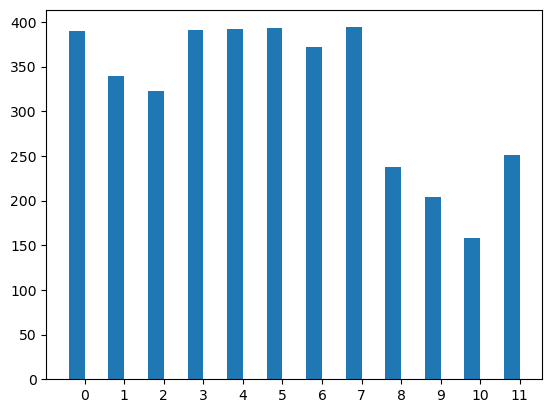

In [10]:
indexes = np.arange(len(labels))
width = 0.4

plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Due to the class imbalance shown in the bar plot above and due to the limitation of our chosen models (especially the capacity limitation of the HopeField Network), we'll focus only on classes 0, and 3 to 7. <br>
Also, we'll convert the images to grayscale instead of RGB.

In [11]:
data_iterator.class_indices

{'burj_khalifa': 0,
 'chichen_itza': 1,
 'christ_the_reedemer': 2,
 'eiffel_tower': 3,
 'great_wall_of_china': 4,
 'machu_pichu': 5,
 'pyramids_of_giza': 6,
 'roman_colosseum': 7,
 'statue_of_liberty': 8,
 'stonehenge': 9,
 'taj_mahal': 10,
 'venezuela_angel_falls': 11}

In [12]:
newClasses = []
for key, val in data_iterator.class_indices.items():
    if val == 0 or (val >= 3 and val <= 7):
        newClasses.append(key)
newClasses

['burj_khalifa',
 'eiffel_tower',
 'great_wall_of_china',
 'machu_pichu',
 'pyramids_of_giza',
 'roman_colosseum']

In [32]:
# could use image_dataset_from_directory instead of ImageDataGenerator and flow_from_directory, but since we can't take certain folders (classes) using its arguments, we'll use the depracted method
# ds = image_dataset_from_directory('Dataset/', labels='inferred', label_mode='categorical')
datagen = ImageDataGenerator(rescale=1/255.0) # rescaling the data to convert pixels from range of [0, 255] to [0, 1]
# prepare an iterators for each dataset
data_iterator = datagen.flow_from_directory('Dataset/', classes=newClasses, class_mode='binary', 
                                        target_size=(128,128), seed=42, batch_size=1, color_mode='grayscale', shuffle=False)
# even though our classification problem is not "binary", we're putting it as an argument 
# because we want the labels as they are, as the models will have the task of one-hot encoding them
# batch_size is set to 1, as we want to iterate over each image to flatten it to be used as input for the models
# shuffle is set to False, as we don't want to randomize sampled images in each batch

Found 2332 images belonging to 6 classes.


In [33]:
imgsPerClass = Counter(data_iterator.classes)
print(*imgsPerClass.items())

(0, 390) (1, 391) (2, 392) (3, 393) (4, 372) (5, 394)


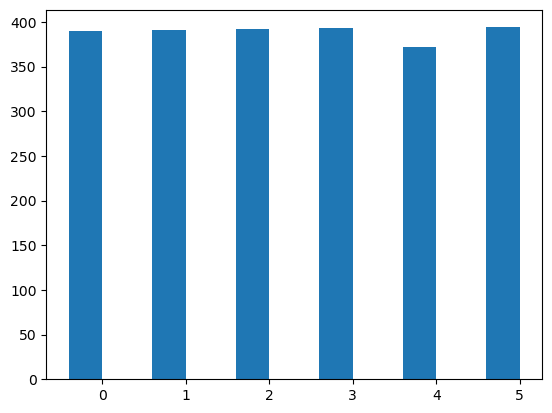

In [34]:
labels, freq = zip(*imgsPerClass.items())
indexes = np.arange(len(labels))
width = 0.4

plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [35]:
for batch in data_iterator: # just for visualizing
    batchofXs = batch[0]
    batchofYs = batch[1]
    print('shape of 1st image:', np.array(batchofXs[0]).shape) 
    print('when flattened:', np.array(batchofXs[0]).flatten().shape)
    print('value of 1st label:', batchofYs[0])
    print('value of 1st image:\n', batchofXs[0])
    break

shape of 1st image: (128, 128, 1)
when flattened: (16384,)
value of 1st label: 0.0
value of 1st image:
 [[[0.627451  ]
  [0.62352943]
  [0.62352943]
  ...
  [0.49803925]
  [0.49803925]
  [0.49803925]]

 [[0.62352943]
  [0.61960787]
  [0.61960787]
  ...
  [0.49803925]
  [0.49803925]
  [0.49411768]]

 [[0.61960787]
  [0.62352943]
  [0.61960787]
  ...
  [0.5019608 ]
  [0.5058824 ]
  [0.5019608 ]]

 ...

 [[0.24313727]
  [0.25882354]
  [0.26666668]
  ...
  [0.5176471 ]
  [0.5137255 ]
  [0.54901963]]

 [[0.23137257]
  [0.23529413]
  [0.30980393]
  ...
  [0.5137255 ]
  [0.5019608 ]
  [0.5529412 ]]

 [[0.2392157 ]
  [0.28627452]
  [0.29411766]
  ...
  [0.48235297]
  [0.53333336]
  [0.5058824 ]]]


In [45]:
x = []
y = []
for i, batch in enumerate(data_iterator):
    if i == data_iterator.samples: # break when all images in the folders are processed
        break
    x.append(np.array(batchofXs[0]).flatten()) # flattening the image
    y.append(int(batch[1])) # converting labels to int instead of float
len(x), len(y)

(2332, 2332)

In [46]:
pklSave(x, 'x.pkl')
pklSave(y, 'y.pkl')

In [47]:
x = pklLoad('x.pkl', convertToNumpyArray=True)
y = pklLoad('y.pkl', convertToNumpyArray=True)

In [48]:
x.shape, y.shape

((2332, 16384), (2332,))

The following code will be at the start of each of the models' .ipynb files

In [49]:
# x = pklLoad('../x.pkl', convertToNumpyArray=True)
# y = pklLoad('../y.pkl', convertToNumpyArray=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [50]:
len(x_train), len(x_test), len(y_train), len(y_test)

(1865, 467, 1865, 467)

# Feature Extraction using PCA
due to the used models' limitation, we'll also use PCA to extract the most important features from each image and store that in another pickle file